In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sklearn
import pandas as pd

# Load the data

In [3]:
dat = pd.read_csv('data/wdbc_w_header.csv',index_col=0)
dat = dat.fillna(0)
dat.shape

(569, 31)

In [4]:
dat.head()

,diagnosis,radius.mean,radius.std,radius.max,texture.mean,texture.std,texture.max,perimeter.mean,perimeter.std,perimeter.max,...,concavity.max,concave points.mean,concave points.std,concave points.max,symmetry .mean,symmetry .std,symmetry .max,fractal dimension.mean,fractal dimension.std,fractal dimension.max
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Select only the two features used in the original paper

In [152]:
X = dat.loc[:,['radius.mean','symmetry .max']].values
X[:10]

array([[17.99  ,  0.7119],
       [20.57  ,  0.2416],
       [19.69  ,  0.4504],
       [11.42  ,  0.6869],
       [20.29  ,  0.4   ],
       [12.45  ,  0.5355],
       [18.25  ,  0.3784],
       [13.71  ,  0.2678],
       [13.    ,  0.539 ],
       [12.46  ,  1.105 ]])

# Assign diagnosis values to True/False

In [153]:
y = dat.diagnosis.values=='M'
y[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# Create classification plots like the [Scikit-learn demo](https://scikit-learn.org/stable/modules/svm.html#svm-classification)

In [166]:
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

In [204]:
from sklearn import svm
from sklearn import tree

def make_meshgrid(x, y, h=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() * .9, x.max() * 1.1
    y_min, y_max = y.min() * .9, y.max() * 1.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                         np.linspace(y_min, y_max, h))
    return xx, yy


In [283]:
models = [
    tree.DecisionTreeClassifier(max_depth=2,class_weight='balanced'),
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=3),
    sklearn.linear_model.LogisticRegression(class_weight='balanced',solver='lbfgs'),
    svm.SVC(kernel='poly', degree=3, class_weight='balanced', gamma='scale')
]

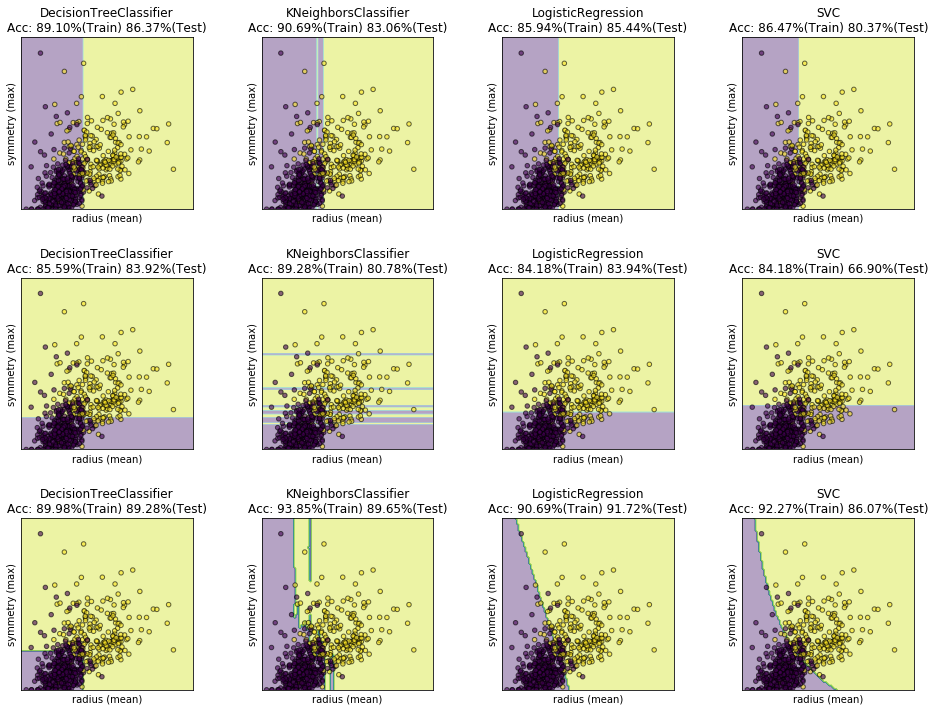

In [286]:
fig, sub = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(16,12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

def makeTitle(clf,train_acc,test_acc):
    return '%s\nAcc: %.2f%%(Train) %.2f%%(Test)'%(
        str(type(clf)).rsplit('.',1)[1].rstrip("'>"),
        100*train_acc,
        100*test_acc
    )

models = [clf.fit(X[:,:1], y) for clf in models]
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()][:,:1])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
for clf, title, ax in zip(models, titles, sub.flatten()[:4]):
    plot_contours(ax, clf, xx, yy, alpha=0.4)
    test_acc = sklearn.model_selection.cross_validate(
        clf, 
        sklearn.preprocessing.StandardScaler().fit_transform(X)[:,:1], 
        y, 
        scoring=['balanced_accuracy'], 
        cv=10, 
        return_train_score=False
    )['test_balanced_accuracy'].mean()
    train_acc = sklearn.metrics.accuracy_score(y,clf.predict(X[:,:1]))
    
    ax.scatter(X0, X1, c=y, s=20, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('radius (mean)')
    ax.set_ylabel('symmetry (max)')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(makeTitle(clf,train_acc,test_acc))
    
models = [clf.fit(X[:,1:], y) for clf in models]
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()][:,1:])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
for clf, title, ax in zip(models, titles, sub.flatten()[4:8]):
    plot_contours(ax, clf, xx, yy, alpha=0.4)
    test_acc = sklearn.model_selection.cross_validate(
        clf, 
        sklearn.preprocessing.StandardScaler().fit_transform(X)[:,1:], 
        y, 
        scoring=['balanced_accuracy'], 
        cv=10, 
        return_train_score=False
    )['test_balanced_accuracy'].mean()
    train_acc = sklearn.metrics.accuracy_score(y,clf.predict(X[:,1:]))
    
    ax.scatter(X0, X1, c=y, s=20, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('radius (mean)')
    ax.set_ylabel('symmetry (max)')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(makeTitle(clf,train_acc,test_acc))
    
models = [clf.fit(X, y) for clf in models]
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
for clf, title, ax in zip(models, titles, sub.flatten()[8:]):
    plot_contours(ax, clf, xx, yy, alpha=0.4)
    test_acc = sklearn.model_selection.cross_validate(
        clf, 
        sklearn.preprocessing.StandardScaler().fit_transform(X), 
        y, 
        scoring=['balanced_accuracy'], 
        cv=10, 
        return_train_score=False
    )['test_balanced_accuracy'].mean()
    train_acc = sklearn.metrics.accuracy_score(y,clf.predict(X))
    
    ax.scatter(X0, X1, c=y, s=20, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('radius (mean)')
    ax.set_ylabel('symmetry (max)')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(makeTitle(clf,train_acc,test_acc))


# What is "cross validaton?"

![sklearn guide on CV](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

# Use only the three features selected in the original paper

In [107]:
X = dat.loc[:,['texture.mean','area.max','smoothness.max']].values
y = dat.iloc[:,0].values=='M'

In [108]:
clf = svm.SVC(kernel='poly', degree=3, C=1.0, class_weight='balanced', gamma='scale')

In [268]:
scores = sklearn.model_selection.cross_validate(
    clf, 
    sklearn.preprocessing.StandardScaler().fit_transform(X), 
    y, 
    scoring=[
        'balanced_accuracy',
        'roc_auc',
        'precision_macro',
        'recall_macro'
    ], 
    cv=10, 
    return_train_score=False
)
scores

{'fit_time': array([0.00605702, 0.00469041, 0.00469637, 0.00451732, 0.00435948,
        0.00431204, 0.00405979, 0.00393605, 0.00390077, 0.00380206]),
 'score_time': array([0.0061934 , 0.00564289, 0.00532699, 0.00509   , 0.00494099,
        0.004843  , 0.00462508, 0.00440979, 0.00430298, 0.00422239]),
 'test_balanced_accuracy': array([0.84974747, 0.80429293, 0.7718254 , 0.79563492, 0.83333333,
        0.92857143, 0.92857143, 0.89047619, 0.92380952, 0.88095238]),
 'test_roc_auc': array([0.96590909, 0.90656566, 0.97222222, 0.9510582 , 0.98809524,
        0.99074074, 0.95899471, 0.97006803, 0.98911565, 0.99319728]),
 'test_precision_macro': array([0.8974175 , 0.87364341, 0.85926573, 0.87126246, 0.91860465,
        0.96153846, 0.96153846, 0.91959064, 0.92380952, 0.9375    ]),
 'test_recall_macro': array([0.84974747, 0.80429293, 0.7718254 , 0.79563492, 0.83333333,
        0.92857143, 0.92857143, 0.89047619, 0.92380952, 0.88095238])}

In [110]:
'Accuracy: %.3f +/- %.3f'%(scores['test_balanced_accuracy'].mean(),scores['test_balanced_accuracy'].std())

'Accuracy: 0.838 +/- 0.064'

# Select features based on a Linear Support Vector Classifier
Selects based on the top linear coefficients

In [126]:
X = sklearn.preprocessing.StandardScaler().fit_transform(dat.iloc[:,1:].values)
y = dat.iloc[:,0].values=='M'

In [127]:
selector = sklearn.feature_selection.SelectFromModel(
    sklearn.svm.LinearSVC(
        C=.01, 
        penalty="l1",
        dual=False
    ).fit(X,y),
    prefit=True
)

In [128]:
X_selected = selector.transform(X)
X_selected.shape

(569, 7)

In [129]:
print('\n'.join(dat.columns[1+selector.transform(np.array([range(X.shape[1])]))[0]]))

perimeter.std
area.std
concavity.max
concave points.mean
symmetry .mean
fractal dimension.mean
fractal dimension.std


# Perform Cross Validation on a Support Vector Classifier using a Radial Basis Function kernel

In [130]:
clf = svm.SVC(kernel='rbf', C=C, class_weight='balanced', gamma='scale')

In [132]:
scores = sklearn.model_selection.cross_validate(
    clf, 
    X_selected, 
    y, 
    scoring=[
        'balanced_accuracy',
        'roc_auc',
        'precision_macro',
        'recall_macro'
    ], 
    cv=10, 
    return_train_score=False
)
scores

{'fit_time': array([0.00584316, 0.00559449, 0.00494361, 0.00493789, 0.00473237,
        0.00456667, 0.00411892, 0.00426674, 0.00447035, 0.00411081]),
 'score_time': array([0.0064919 , 0.00597715, 0.00559878, 0.00533319, 0.00511599,
        0.00496316, 0.00477624, 0.00465322, 0.00456715, 0.00439453]),
 'test_balanced_accuracy': array([0.98611111, 0.97727273, 0.96230159, 0.97619048, 0.97222222,
        0.96230159, 0.91468254, 1.        , 1.        , 0.97142857]),
 'test_roc_auc': array([0.99873737, 0.99494949, 0.99206349, 0.99867725, 0.99867725,
        0.99867725, 0.98544974, 1.        , 1.        , 0.99727891]),
 'test_precision_macro': array([0.97826087, 0.98648649, 0.96230159, 0.98648649, 0.95652174,
        0.96230159, 0.93421053, 1.        , 1.        , 0.95652174]),
 'test_recall_macro': array([0.98611111, 0.97727273, 0.96230159, 0.97619048, 0.97222222,
        0.96230159, 0.91468254, 1.        , 1.        , 0.97142857])}

In [135]:
print('Accuracy: %.3f +/- %.3f'%(scores['test_balanced_accuracy'].mean(),scores['test_balanced_accuracy'].std()))
print('Precision: %.3f +/- %.3f'%(scores['test_precision_macro'].mean(),scores['test_precision_macro'].std()))
print('Recall(Sensitivity): %.3f +/- %.3f'%(scores['test_recall_macro'].mean(),scores['test_recall_macro'].std()))

Accuracy: 0.972 +/- 0.023
Precision: 0.972 +/- 0.020
Recall(Sensitivity): 0.972 +/- 0.023
